## Customer Churn Analysis with PySpark

In [ ]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.functions import col, isnan, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
spark = SparkSession.builder.appName("ChurnEDA").getOrCreate()

In [ ]:
# Load the dataset
df = spark.read.csv("BankChurners.csv", header=True, inferSchema=True)

In [ ]:
# Drop unwanted columns
df = df.drop("Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
             "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2")


In [ ]:
#Summary Statistics

In [ ]:
df.show(5)

+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------

In [ ]:
# Check for missing values
df.select([when(isnan(col(c)) | col(c).isNull(), 1).alias(c) for c in df.columns]).show(5)

+---------+--------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+
|CLIENTNUM|Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+---------+--------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--

In [ ]:
# Check distribution of categorical columns
df.groupBy("Attrition_Flag").count().show()
df.groupBy("Card_Category").count().show()
df.groupBy("Income_Category").count().show()
df.groupBy("Education_Level").count().show()
df.groupBy("Marital_Status").count().show()
df.groupBy("Income_Category").agg(avg("Credit_Limit")).show()

+-----------------+-----+
|   Attrition_Flag|count|
+-----------------+-----+
|Existing Customer| 8500|
|Attrited Customer| 1627|
+-----------------+-----+

+-------------+-----+
|Card_Category|count|
+-------------+-----+
|     Platinum|   20|
|       Silver|  555|
|         Blue| 9436|
|         Gold|  116|
+-------------+-----+

+---------------+-----+
|Income_Category|count|
+---------------+-----+
|        $120K +|  727|
|    $60K - $80K| 1402|
|   $80K - $120K| 1535|
|        Unknown| 1112|
|    $40K - $60K| 1790|
| Less than $40K| 3561|
+---------------+-----+

+---------------+-----+
|Education_Level|count|
+---------------+-----+
|    High School| 2013|
|        Unknown| 1519|
|     Uneducated| 1487|
|  Post-Graduate|  516|
|      Doctorate|  451|
|       Graduate| 3128|
|        College| 1013|
+---------------+-----+

+--------------+-----+
|Marital_Status|count|
+--------------+-----+
|       Unknown|  749|
|       Married| 4687|
|      Divorced|  748|
|        Single| 3943|

In [ ]:
# Histogram for customer age
df.select("Customer_Age").summary("count", "mean", "min", "max").show()

+-------+-----------------+
|summary|     Customer_Age|
+-------+-----------------+
|  count|            10127|
|   mean|46.32596030413745|
|    min|               26|
|    max|               73|
+-------+-----------------+



In [ ]:
# View statistics for Credit Limit and Total Transaction Amount
df.select("Credit_Limit", "Total_Trans_Amt").summary("count", "mean", "min", "max").show()

+-------+-----------------+-----------------+
|summary|     Credit_Limit|  Total_Trans_Amt|
+-------+-----------------+-----------------+
|  count|            10127|            10127|
|   mean|8631.953698034848|4404.086303939963|
|    min|           1438.3|              510|
|    max|          34516.0|            18484|
+-------+-----------------+-----------------+



In [ ]:
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

In [ ]:
# Convert to Pandas for easier visualization
df_pandas = df.toPandas()

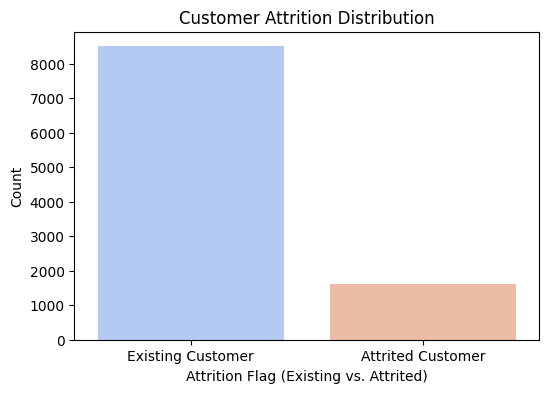

In [ ]:
# Customer Attrition Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df_pandas, x="Attrition_Flag", hue="Attrition_Flag", palette="coolwarm", legend=False)
plt.title("Customer Attrition Distribution")
plt.xlabel("Attrition Flag (Existing vs. Attrited)")
plt.ylabel("Count")
plt.show()

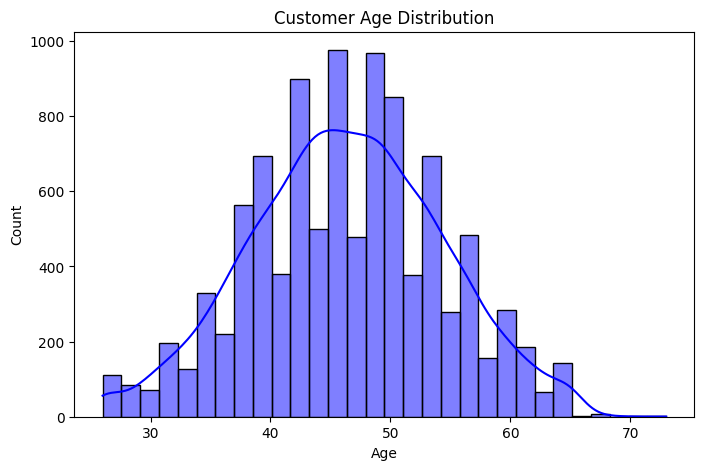

In [ ]:
# Age Distribution
plt.figure(figsize=(8,5))
sns.histplot(df_pandas["Customer_Age"], bins=30, kde=True, color="blue")
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


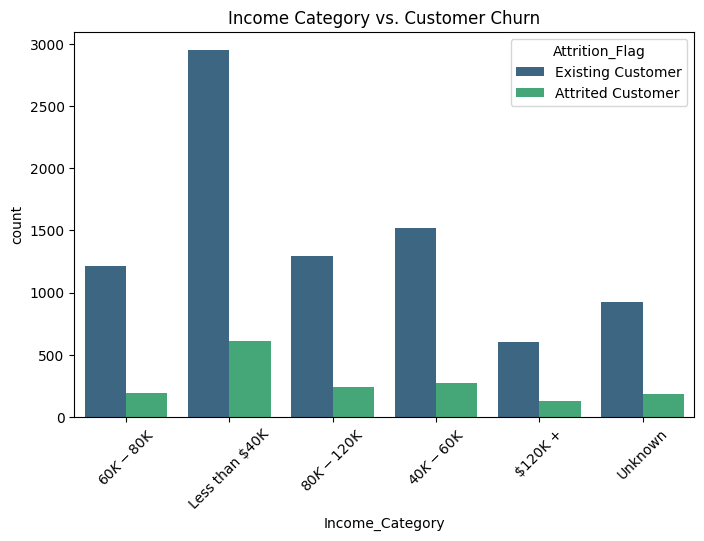

In [ ]:
# Income Category vs. Attrition
plt.figure(figsize=(8,5))
sns.countplot(data=df_pandas, x="Income_Category", hue="Attrition_Flag", palette="viridis")
plt.title("Income Category vs. Customer Churn")
plt.xticks(rotation=45)
plt.show()

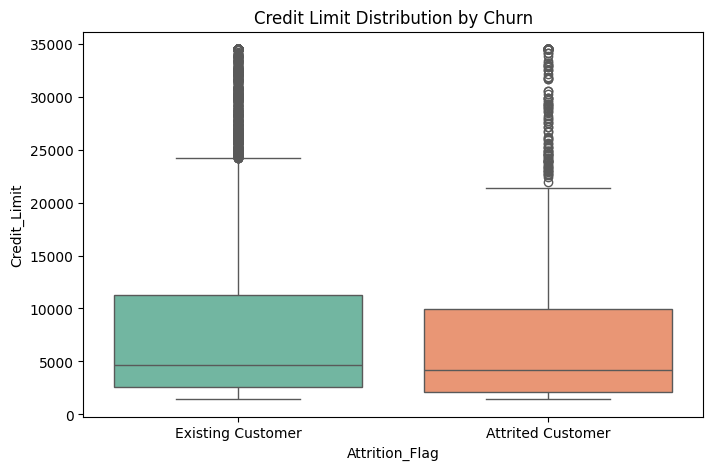

In [ ]:
# Credit Limit vs. Churn
plt.figure(figsize=(8,5))
sns.boxplot(x="Attrition_Flag", y="Credit_Limit",hue="Attrition_Flag", data=df_pandas, palette="Set2")
plt.title("Credit Limit Distribution by Churn")
plt.show()

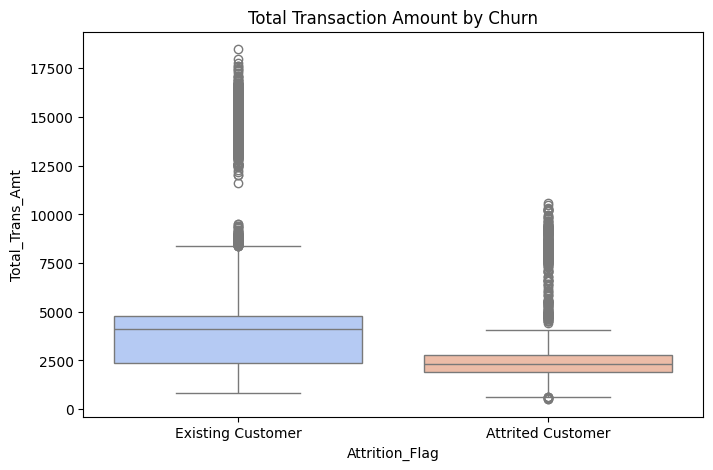

In [ ]:
# Transactions & Customer Behavior
plt.figure(figsize=(8,5))
sns.boxplot(x="Attrition_Flag", y="Total_Trans_Amt",hue="Attrition_Flag", data=df_pandas, palette="coolwarm")
plt.title("Total Transaction Amount by Churn")
plt.show()